In [1]:
pref = {
    "angular_resolution": 1,
    "aspect_ratio": 1,
    "crossing_angle": 2,
    "crossing_number": 2,
    "gabriel_graph_property": 1,
    "ideal_edge_length": 1,
    "node_resolution": 1,
    "neighborhood_preservation": 3,
    "runtime": 0.5,
    "stress": 2,
}

In [2]:
# Standard Library
import argparse
from time import perf_counter

# Third Party Library
import matplotlib.pyplot as plt
import networkx as nx
import optuna
import pandas as pd
from egraph import Drawing, all_sources_bfs
from ex_utils.config.dataset import dataset_names
from ex_utils.config.paths import get_dataset_path
from ex_utils.config.quality_metrics import qm_names
from ex_utils.share import (
    draw,
    draw_and_measure,
    ex_path,
    generate_base_df_data,
)
from ex_utils.utils.graph import (
    egraph_graph,
    load_nx_graph,
    nx_graph_preprocessing,
)
from tqdm import tqdm
import plotly.graph_objects as go

/Users/fuga_takata/dev/vdslab-project/hyperparameter-in-graph-drawing/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


23 111 0.1291549665014884
67 45 1.0
67 45 1.0


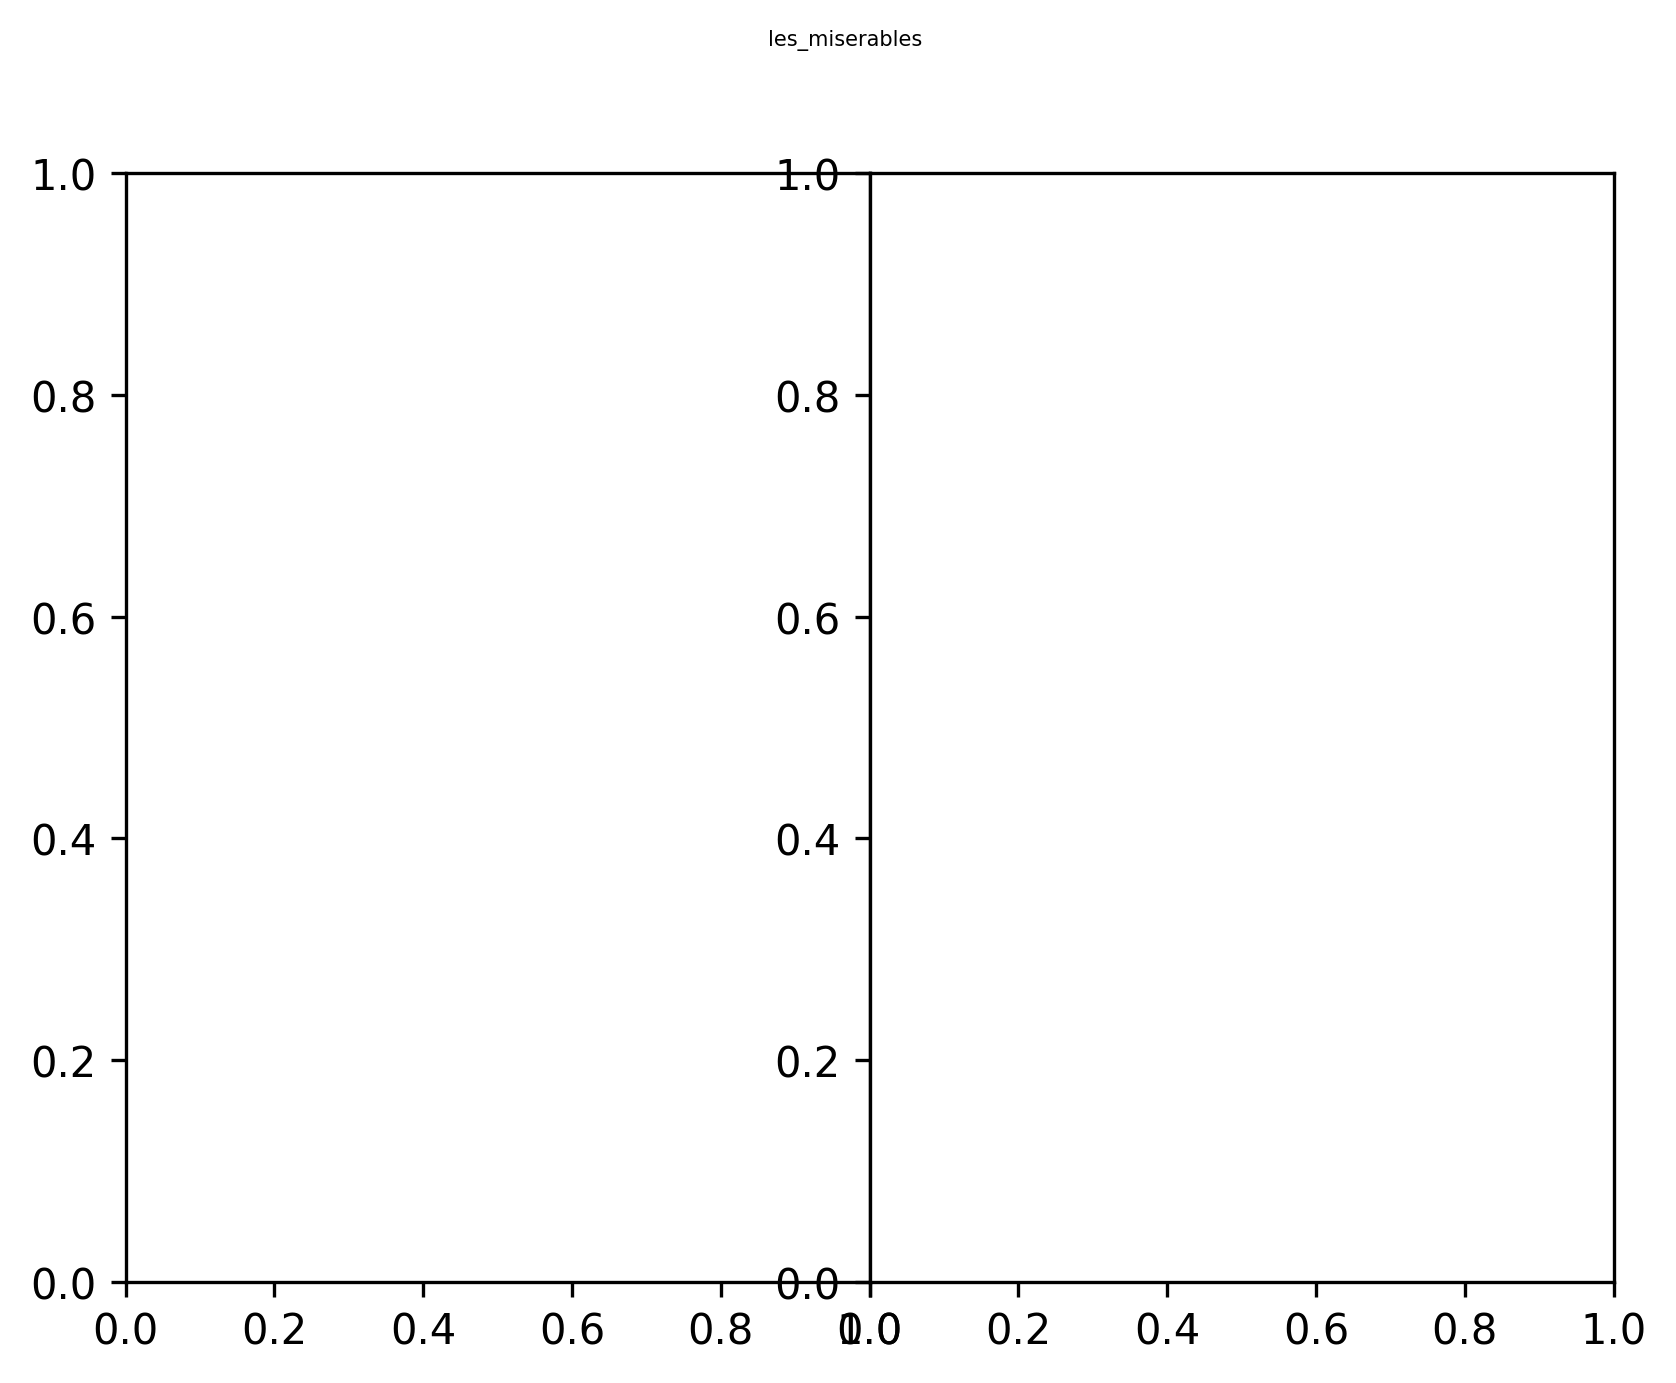

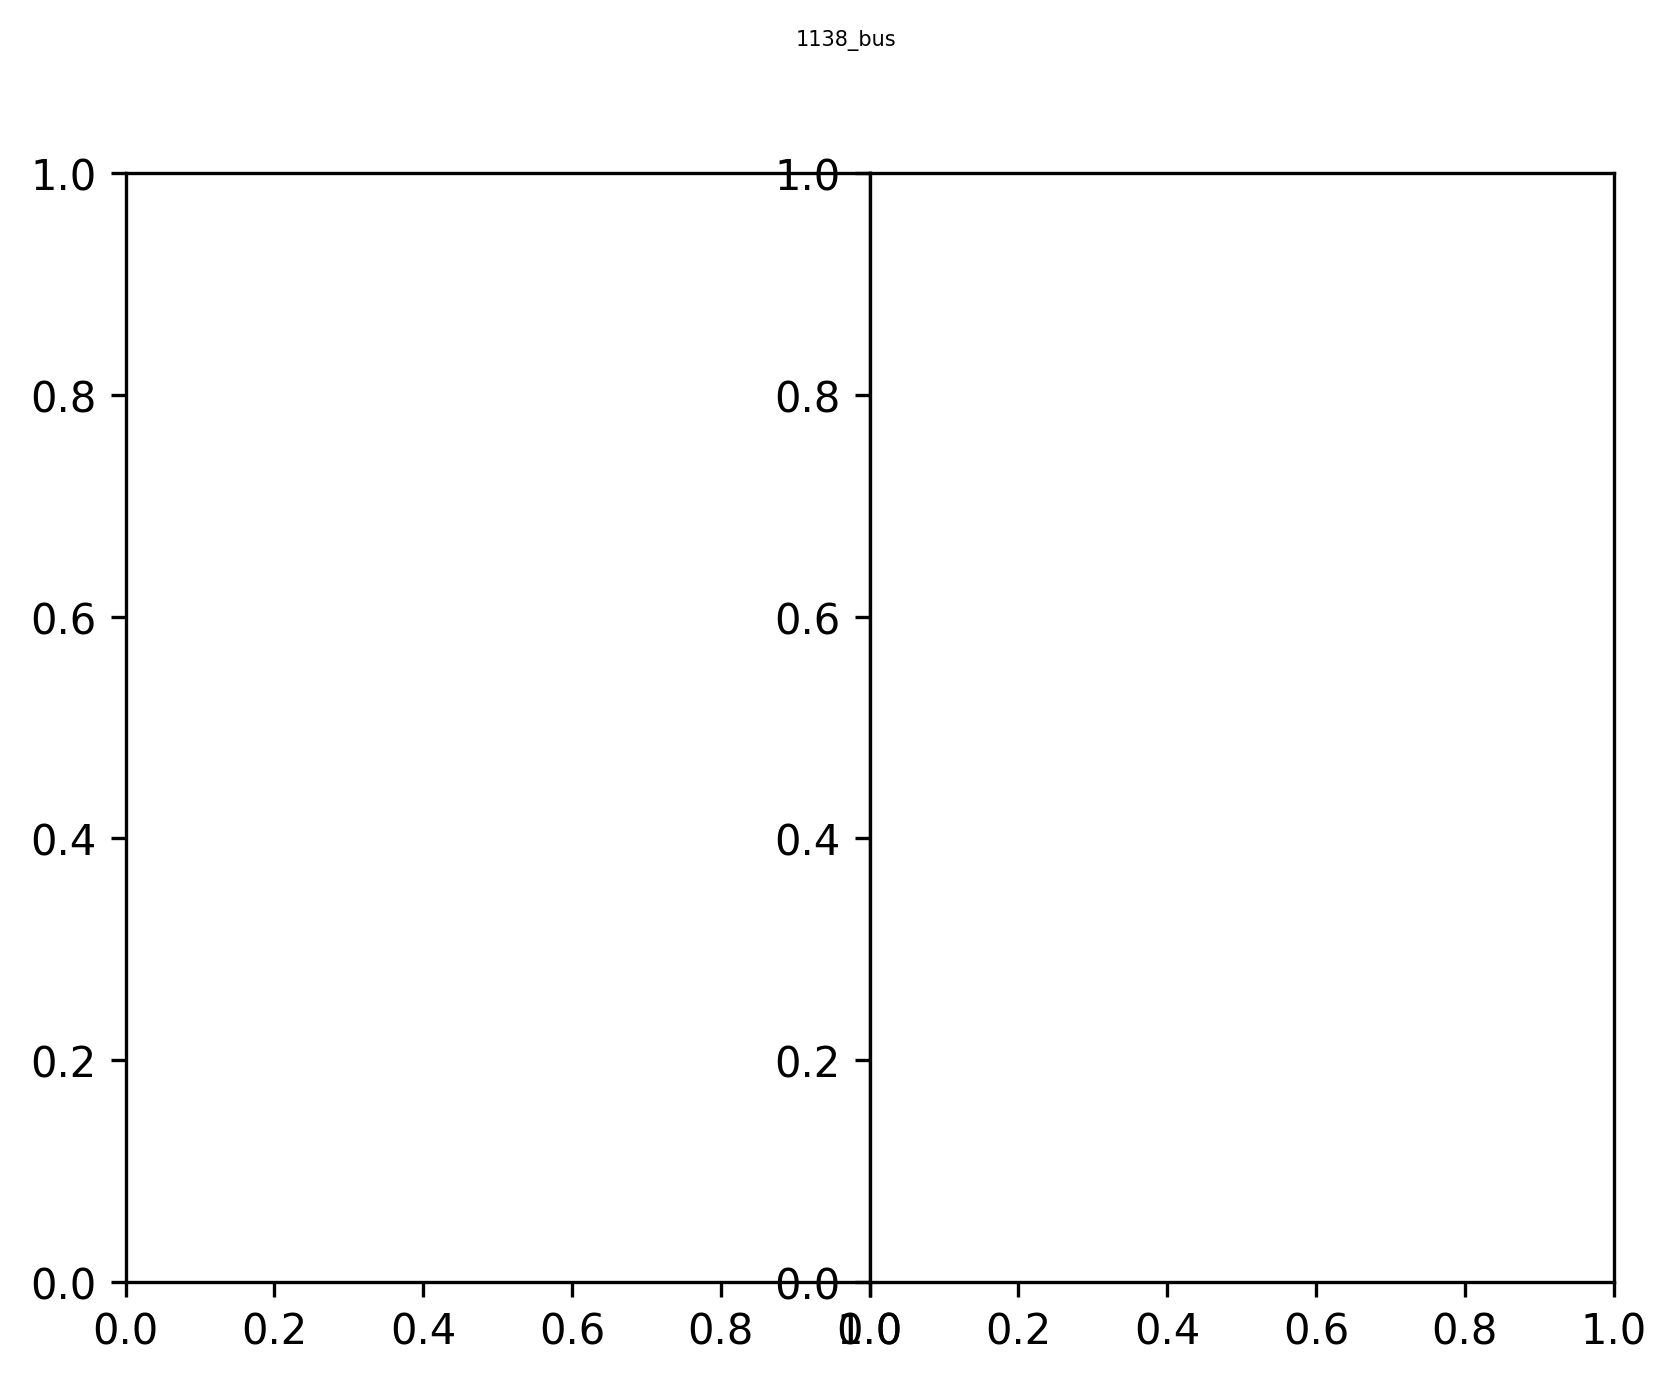

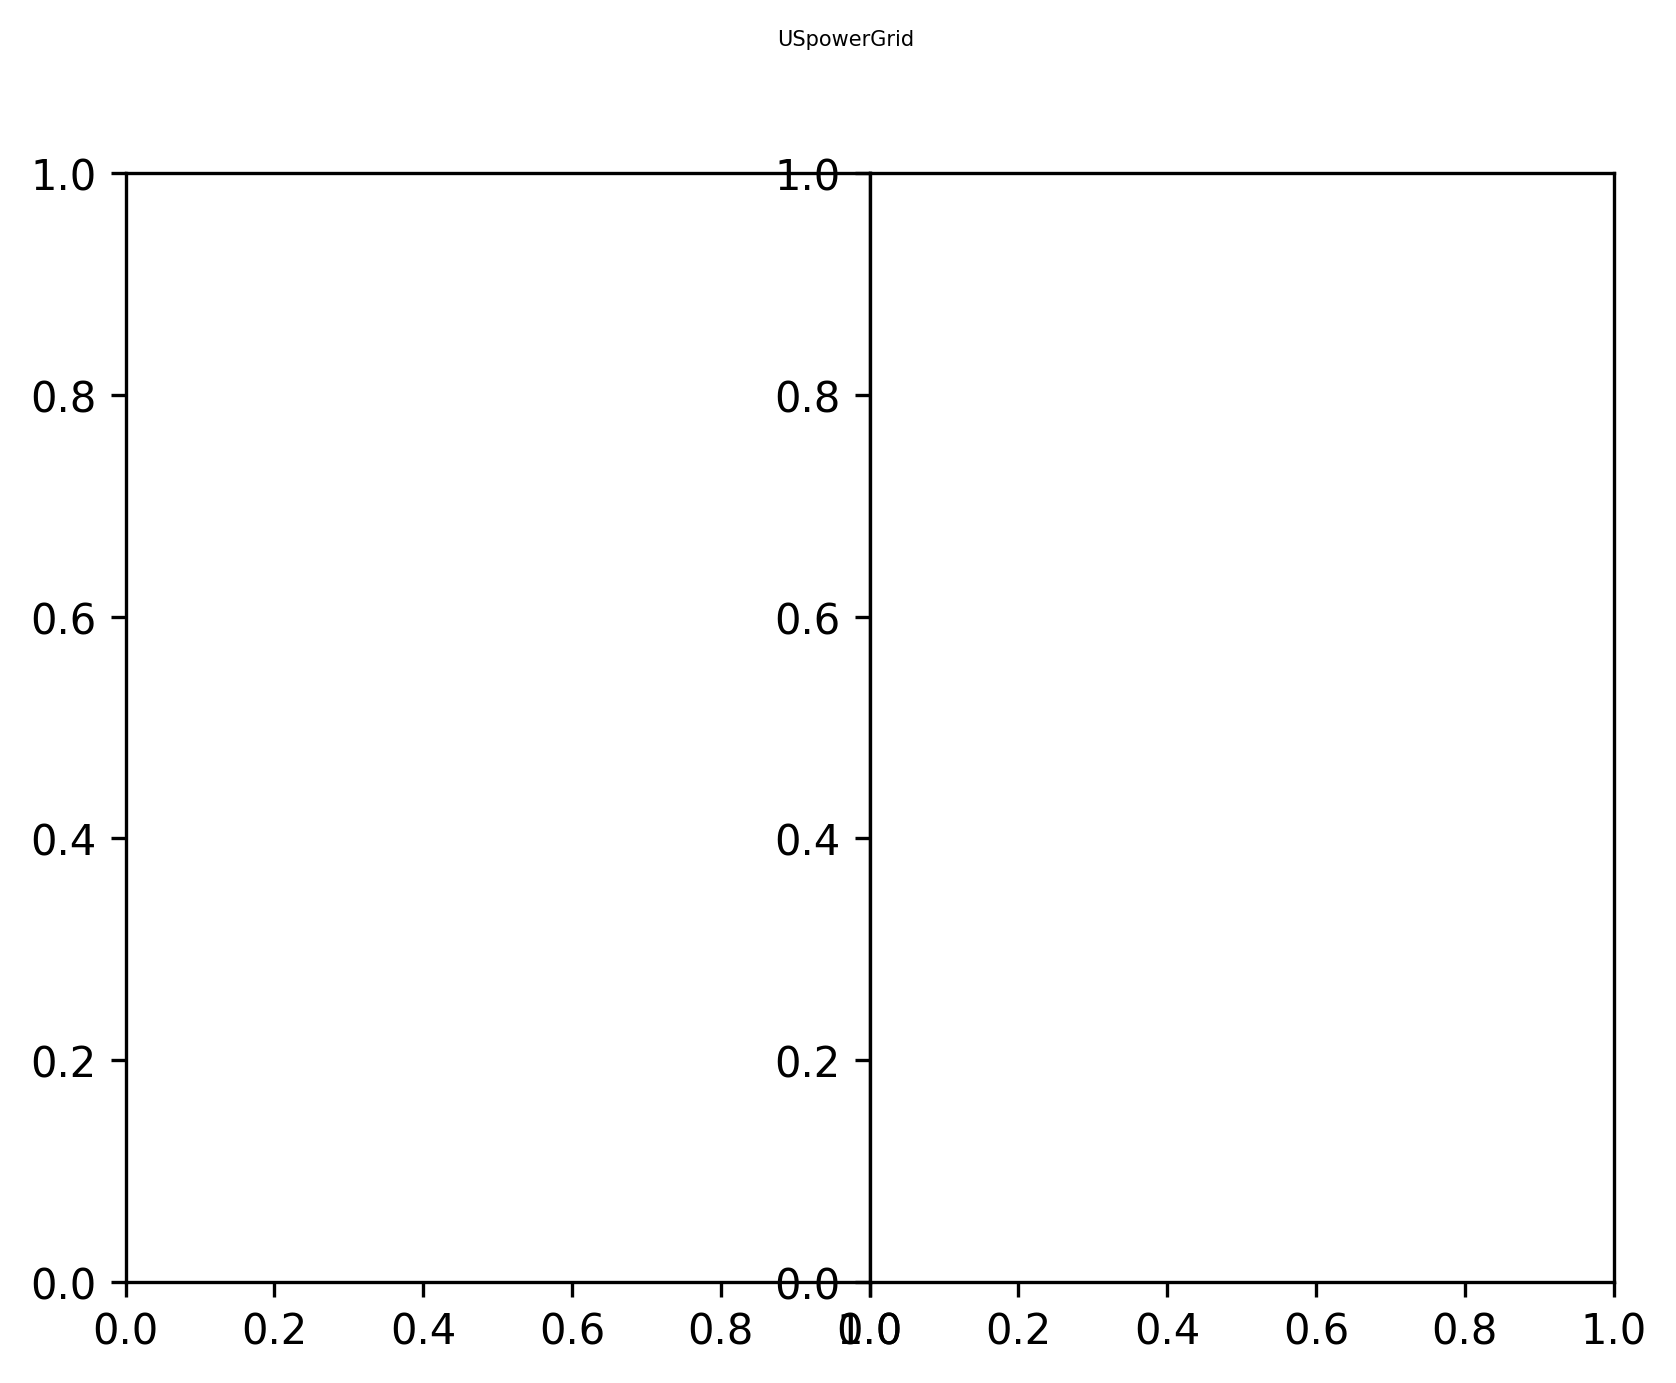

In [3]:
EDGE_WEIGHT = 30
n_rows = 1
n_cols = 2

limit = n_rows * n_cols

for D in ["les_miserables", "1138_bus", "USpowerGrid"]:
    n_split = 10
    data_seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    df = pd.read_pickle(
        ex_path.joinpath(
            f"data/grid/{D}/seed={','.join(map(str, data_seeds))}_n={n_split}.pkl"
        )
    )

    for i, row in df.iterrows():
        ss_weighted_sum = 0
        mms_weighted_sum = 0
        row_dict = row.to_dict()
        for qm_name in qm_names:
            ss_weighted_sum += (
                row_dict[f"values_sscaled_{qm_name}"] * pref[qm_name]
            )
            mms_weighted_sum += (
                row_dict[f"values_mmscaled_{qm_name}"] * pref[qm_name]
            )

        df.at[i, "ss_weighted_sum"] = ss_weighted_sum
        df.at[i, "mms_weighted_sum"] = mms_weighted_sum
    df_mms_weighted = df.sort_values("mms_weighted_sum", ascending=False)
    df_ss_weighted = df.sort_values("ss_weighted_sum", ascending=False)

    dataset_path = get_dataset_path(dataset_name=D)
    nx_graph = nx_graph_preprocessing(
        load_nx_graph(dataset_path=dataset_path), EDGE_WEIGHT
    )

    eg_graph, eg_indices = egraph_graph(nx_graph=nx_graph)

    eg_drawing = Drawing.initial_placement(eg_graph)
    eg_distance_matrix = all_sources_bfs(eg_graph, EDGE_WEIGHT)

    o = 1
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, dpi=300, facecolor="white"
    )
    fig.suptitle(D, fontsize=5)
    fig.subplots_adjust(wspace=0, hspace=0)
    df_head = df_ss_weighted.head(limit)
    for (i, row), ax in zip(df_head.iterrows(), axes.flatten()):
        params = {
            "pivots": int(row.params_pivots),
            "iterations": int(row.params_iterations),
            "eps": row.params_eps,
        }
        print(params["pivots"], params["iterations"], params["eps"])
        break
        pos = draw(
            params=params,
            eg_graph=eg_graph,
            eg_indices=eg_indices,
            eg_drawing=eg_drawing,
            edge_weight=EDGE_WEIGHT,
            seed=0,
        )

        ax.set_aspect("equal")

        ax.set_title(
            f"""{o} p{params['pivots']}
i{params['iterations']},e{round(params['eps'], 2)}""",
            fontsize=5,
        )

        nx.draw(
            nx_graph,
            pos=pos,
            node_size=0.5,
            node_color="#AB47BC",
            edge_color="#CFD8DC",
            ax=ax,
            alpha=0.6,
        )

        o += 1
    continue
    plt.show()

    N = 500

    db_uri = (
        f"sqlite:///{ex_path.joinpath('results/optimization/optimization.db')}"
    )
    study_name = f"{D}_N={N}_with_runtime"
    study = optuna.load_study(study_name=study_name, storage=db_uri)
    study_df = study.trials_dataframe()
    best_trials_n = [t.number for t in study.best_trials]
    study_df = study_df[study_df["number"].isin(best_trials_n)]
    pn = ["pivots", "iterations", "eps"]
    study_df["type"] = 0
    df_head["type"] = 1

    p_head = df_head["params_pivots"]
    i_head = df_head["params_iterations"]
    e_head = df_head["params_eps"]

    for p, i, e in zip(p_head, i_head, e_head):
        study_df = study_df.query(
            " | ".join(
                [
                    f"({p - 5} < params_pivots & params_pivots < {p + 5} & {i - 10} < params_iterations & params_iterations < {i + 10} & {e - 0.1} < params_eps & params_eps < {e + 0.1})"
                    for p, i, e in zip(p_head, i_head, e_head)
                ]
            )
        )
    display(study_df)

    mdf = pd.concat([study_df, df_head])

    dimensions = [
        dict(
            range=[
                min(mdf[f"params_{ppn}"]),
                max(mdf[f"params_{ppn}"]),
            ],
            label=ppn,
            values=mdf[f"params_{ppn}"],
        )
        for ppn in pn
    ]

    fig = go.Figure(
        data=go.Parcoords(
            line=dict(
                color=mdf["type"],
                colorscale=[[0, "#3F51B5"], [1, "#FFC107"]],
                # colorscale=[[0, "#3F51B5"], [1, "yellow"]],
            ),
            dimensions=list(dimensions),
        )
    )

    fig.show()